In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearnex import patch_sklearn
patch_sklearn()
from hpsklearn import *
from hyperopt import hp, tpe

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
SEED = 10

In [3]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-02-22 03:08:11.


In [4]:
filepath = "../Data Preprocessing/iot23_combined_100k.csv"
df = pd.read_csv(filepath)

In [5]:
df

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1,1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
2,2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
3,3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0
4,4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,Benign,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444669,99994,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1444670,99995,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1444671,99996,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0
1444672,99997,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,PartOfAHorizontalPortScan,...,0,0,0,1,0,0,0,0,0,0


In [6]:
del df['Unnamed: 0']

In [7]:
df['label'].value_counts()

PartOfAHorizontalPortScan     825939
Okiru                         262690
Benign                        197809
DDoS                          138777
C&C                            15100
Attack                          3915
C&C-HeartBeat                    349
C&C-FileDownload                  43
C&C-Torii                         30
FileDownload                      13
C&C-HeartBeat-FileDownload         8
C&C-Mirai                          1
Name: label, dtype: int64

In [8]:
good = 'Benign'
bad = 'PartOfAHorizontalPortScan'
filtered_labels = df['label'].value_counts().index.drop([good,bad])
for label in filtered_labels:
    df.drop(df[df.label == label].index, inplace=True) 
print(filtered_labels)
df['label'].value_counts()

Index(['Okiru', 'DDoS', 'C&C', 'Attack', 'C&C-HeartBeat', 'C&C-FileDownload',
       'C&C-Torii', 'FileDownload', 'C&C-HeartBeat-FileDownload', 'C&C-Mirai'],
      dtype='object')


PartOfAHorizontalPortScan    825939
Benign                       197809
Name: label, dtype: int64

In [9]:
df.loc[(df.label == good), 'label'] = 0
df.loc[(df.label == bad), 'label'] = 1
df = df.astype({'label': int})
df['label'].value_counts()

1    825939
0    197809
Name: label, dtype: int64

In [10]:
#for label in df['label'].value_counts().index:
#    if rank < 3:
#        df.loc[(df.label == label), 'label'] = rank
#    else:
#        df.drop(df[df.label == label].index, inplace=True) 
#    rank += 1
#df = df.astype({'label': int})

In [11]:
X = df[['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'proto_icmp', 'proto_tcp', 'proto_udp', 'conn_state_OTH', 'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0', 'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1', 'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH', 'conn_state_SHR']].values

In [12]:
Y = df['label'].values

In [13]:
df

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,2.998796,0,0,0.0,3.0,180.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,2.998804,0,0,0.0,3.0,180.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.000000,0,0,0.0,1.0,60.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444669,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1444670,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1444671,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1444672,0.000000,0,0,0.0,1.0,40.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=SEED, test_size=0.2)

In [15]:
best_results = {}

success = 0

classifiers = [
    ada_boost('ab'),
    decision_tree('dt'),
    extra_trees('et'),
    gaussian_nb('gnb'),
    gradient_boosting('gb'),
    knn('knn'),
    liblinear_svc('svc-ll'),
    linear_discriminant_analysis('lda',n_components=1),
    multinomial_nb('mnb'),
    one_vs_one('ovo'),
    one_vs_rest('ovr'),
    output_code('oc'),
    passive_aggressive('pa'),
    quadratic_discriminant_analysis('qda'),
    random_forest('rf'),
    sgd('sgd'),
    svc('svc'),
    svc_linear('svc-l'),
    svc_poly('svc-p'),
    svc_rbf('svc-r'),
    svc_sigmoid('svc-s'),
    xgboost_classification('xgb')
]

for clf in classifiers:
    
    clf_name = clf.name.replace('sklearn_','').replace('Classifier','')
    if clf_name == 'switch':
        clf_name = 'SVC-LL'
    elif 'SVC' in clf_name:
        for arg in clf.named_args:
            if arg[0] == 'kernel':
                clf_name += f'-{arg[1].obj.capitalize()[0]}'
    clf_name = ''.join(c for c in clf_name if (c.isupper() or c == '-'))
    
    print(f'\n******************** {clf_name} ********************')
    
    try:
            
        estim = HyperoptEstimator(classifier=clf,
                                  preprocessing=[min_max_scaler('my_pre',feature_range=(0,1))],
                                  algo=tpe.suggest,
                                  max_evals=20,
                                  trial_timeout=300,
                                  seed=np.random.default_rng(SEED),
                                  n_jobs=-1)

        estim.fit(X_train, Y_train, random_state=SEED)

        score = estim.score(X_test, Y_test)
        
        best_model = estim.best_model()
    
        best_results[clf_name] = (score, best_model)
        print(best_results[clf_name])
        
        success += 1
        
    except Exception as e:
        print(f"********** Could not fit {clf_name}. Reason: '{str(e)}'. **********")
        best_results[clf_name] = (0.0, None)

print(f'****************************************')
print(f'**** Fit success rate: {success}/{len(classifiers)} ****')
print(f'****************************************')


******************** AB ********************
100%|███████████████████████████████████████████████| 20/20 [00:30<00:00, 30.12s/trial, best loss: 0.08752136752136752]
(0.9112820512820513, {'learner': AdaBoostClassifier(learning_rate=0.0007973450504227367, n_estimators=59,
                   random_state=4), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** DT ********************
100%|███████████████████████████████████████████████| 20/20 [00:01<00:00,  1.63s/trial, best loss: 0.08425518925518927]
(0.864, {'learner': DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=8, random_state=3, splitter='random'), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** ET ********************
100%|███████████████████████████████████████████████| 20/20 [00:11<00:00, 11.02s/trial, best loss: 0.08427960927960931]
(0.8640830280830281, {'learner': ExtraTreesClassifier(bootstrap=True, criterion='entropy',
   

100%|███████████████████████████████████████████████| 20/20 [00:01<00:00,  1.68s/trial, best loss: 0.13454212454212455]
(0.8626324786324786, {'learner': GaussianNB(), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** GB ********************
100%|███████████████████████████████████████████████| 20/20 [00:46<00:00, 46.64s/trial, best loss: 0.08425518925518927]
(0.9141245421245421, {'learner': GradientBoostingClassifier(learning_rate=0.019732665262921015,
                           loss='exponential', max_depth=4,
                           max_features=0.4796525919545166, n_estimators=428,
                           random_state=4), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** KN ********************
100%|███████████████████████████████████████████████████████████████████| 1/1 [05:01<00:00, 301.19s/trial, best loss=?]
********** Could not fit KN. Reason: ''. **********

******************** LSVC ********************
100%|████████████████

 88%|██████████████████████████████████████████████████████████████████▌         | 7/8 [00:00<?, ?trial/s, best loss=?]

job exception: The leading minor of order 24 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.



 88%|██████████████████████████████████████████████████████████████████▌         | 7/8 [00:02<?, ?trial/s, best loss=?]
********** Could not fit LDA. Reason: 'The leading minor of order 24 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.'. **********

******************** MNB ********************
100%|███████████████████████████████████████████████| 20/20 [00:01<00:00,  1.53s/trial, best loss: 0.13446886446886452]
(0.8627448107448108, {'learner': MultinomialNB(alpha=0.38), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** OVO ********************
 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:00<?, ?trial/s, best loss=?]

job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)



 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:03<?, ?trial/s, best loss=?]
********** Could not fit OVO. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********

******************** OVR ********************
 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:00<?, ?trial/s, best loss=?]

job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)



 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:05<?, ?trial/s, best loss=?]
********** Could not fit OVR. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********

******************** OC ********************
 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:00<?, ?trial/s, best loss=?]

job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)



 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:06<?, ?trial/s, best loss=?]
********** Could not fit OC. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********

******************** PA ********************
100%|███████████████████████████████████████████████| 20/20 [00:02<00:00,  2.59s/trial, best loss: 0.13323565323565323]
(0.8638144078144078, {'learner': PassiveAggressiveClassifier(C=0.10580618144023571, fit_intercept=False,
                            max_iter=548676042.0, n_jobs=-1, random_state=3,
                            tol=0.003799057710504326, verbose=False), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** QDA ********************
100%|████████████████████████████████████████████████| 20/20 [00:02<00:00,  2.27s/trial, best loss: 0.1357448107448107]


C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


(0.8617728937728938, {'learner': QuadraticDiscriminantAnalysis(reg_param=0.28192310047566127), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** RF ********************
100%|███████████████████████████████████████████████| 20/20 [00:08<00:00,  8.25s/trial, best loss: 0.08425518925518927]
(0.9141587301587302, {'learner': RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=7, n_estimators=374, n_jobs=-1,
                       random_state=4, verbose=False), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** SGD ********************
100%|████████████████████████████████████████████████| 20/20 [00:02<00:00,  2.18s/trial, best loss: 0.1332417582417582]
(0.8637948717948718, {'learner': SGDClassifier(alpha=3.635544519065662e-05, eta0=0.08701776522406507,
              l1_ratio=0.17548168634130723, learning_rate='constant',
              loss='log', max_iter=300476604.0, n_jobs=-1, penalty='elast

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:01<?, ?trial/s, best loss=?]
********** Could not fit SVC-LL. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********

******************** SVC-L ********************
100%|████████████████████████████████████████████████| 20/20 [00:41<00:00, 41.50s/trial, best loss: 0.1332417582417582]
(0.8636141636141637, {'learner': SVC(C=6.991759392024011, cache_size=512, degree=1, gamma='auto',
    kernel='linear', max_iter=186430450.0, random_state=2,
    tol=0.00896552219109305), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** SVC-P ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


  0%|                                                                            | 0/1 [00:01<?, ?trial/s, best loss=?]
********** Could not fit SVC-P. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********

******************** SVC-R ********************
100%|██████████████████████████████████████████████| 20/20 [01:52<00:00, 112.85s/trial, best loss: 0.11988400488400486]
(0.8534310134310135, {'learner': SVC(C=4.748605227189839, cache_size=512, degree=1, gamma=0.009444372150077604,
    max_iter=432657198.0, random_state=3, tol=7.933853944091779e-05), 'preprocs': (MinMaxScaler(),), 'ex_preprocs': ()})

******************** SVC-S ********************
100%|███████████████████████████████████████████████| 20/20 [00:14<00:00, 14.44s/trial, best loss: 0.13349206349206344]
(0.8636092796092796, {'learner': SVC(C=1308.5659152504284, cache_size=512, coef0=0, degree=1,
    gamma=0.020114878493420366, kernel='sigmoid', max_iter=13085973.0,
    random_

C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:35:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(0.9142026862026862, {'learner': XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5701541246097266, colsample_bynode=1,
              colsample_bytree=0.7470728059084097, enable_categorical=False,
              gamma=3.496245955670253e-05, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02687981851587668,
              max_delta_step=0, max_depth=3, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=3800, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0.0020203335588819434, reg_lambda=3.3387683435131232,
              scale_pos_weight=1, seed=3, subsample=0.929945981810019

In [16]:
import json
best_results = dict(sorted(best_results.items()))
print(json.dumps(best_results, indent=4, default=str))

{
    "AB": [
        0.9112820512820513,
        {
            "learner": "AdaBoostClassifier(learning_rate=0.0007973450504227367, n_estimators=59,\n                   random_state=4)",
            "preprocs": [
                "MinMaxScaler()"
            ],
            "ex_preprocs": []
        }
    ],
    "DT": [
        0.864,
        {
            "learner": "DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2,\n                       min_samples_split=8, random_state=3, splitter='random')",
            "preprocs": [
                "MinMaxScaler()"
            ],
            "ex_preprocs": []
        }
    ],
    "ET": [
        0.8640830280830281,
        {
            "learner": "ExtraTreesClassifier(bootstrap=True, criterion='entropy',\n                     max_features=0.3826823680920317, min_samples_leaf=2,\n                     n_estimators=23, n_jobs=-1, random_state=2, verbose=False)",
            "preprocs": [
                "MinMaxScaler()"
            ],


['SVC', 'DT', 'ET', 'GB', 'GNB', 'KN', 'LDA', 'LSVC', 'MNB', 'OC', 'OVO', 'OVR', 'PA', 'QDA', 'RF', 'SGD', 'SVC-L', 'SVC-LL', 'SVC-P', 'SVC-R', 'SVC-S', 'XGB']
[0.9112820512820513, 0.864, 0.8640830280830281, 0.9141245421245421, 0.8626324786324786, 0.0, 0.0, 0.8638095238095238, 0.8627448107448108, 0.0, 0.0, 0.0, 0.8638144078144078, 0.8617728937728938, 0.9141587301587302, 0.8637948717948718, 0.8636141636141637, 0.0, 0.0, 0.8534310134310135, 0.8636092796092796, 0.9142026862026862]


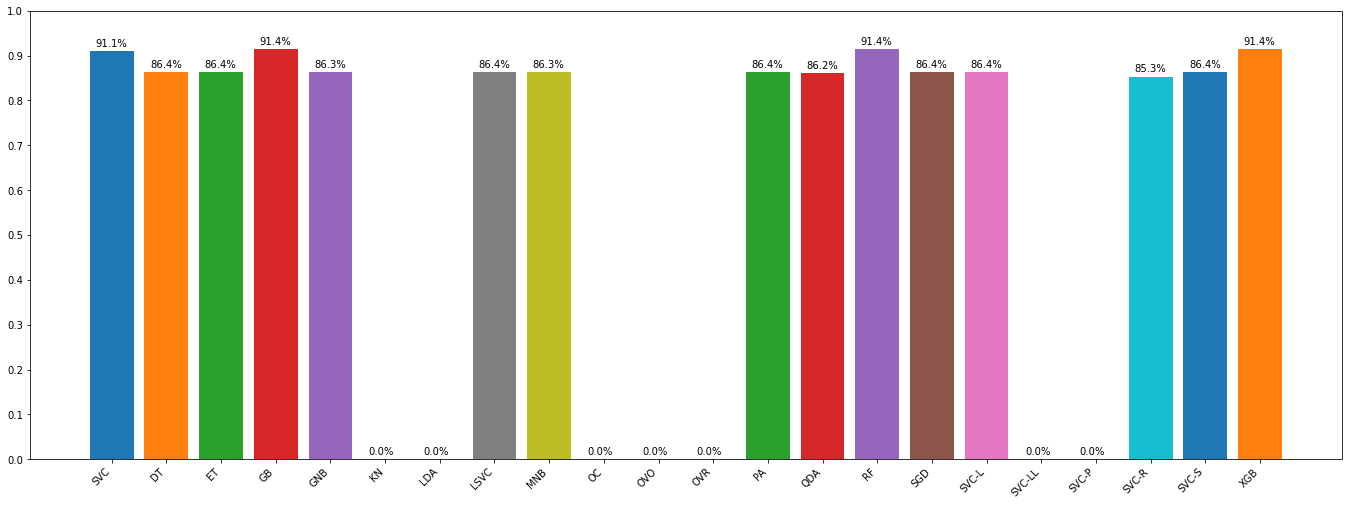

In [17]:
names = list(best_results.keys())
names[0] = 'SVC'
print(names)
values = list(x[0] for x in best_results.values())
print(values)

plt.figure(figsize=(23.5,8.25))
idx = 0
for i in range(len(best_results.keys())):
    plt.bar(names[i],values[i])
    plt.text(idx-0.3,values[i]+0.01,f'{100*values[i]:.1f}%')
    idx += 1
plt.xticks(rotation=45, ha='right')
plt.xticks(range(0,len(best_results)),names)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.show()

In [18]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-02-22 08:39:02.
